# KNN Hinge Loss - example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from src.experiments import run_training_loop
from src.networks import CustomNeuralNetwork
from src.losses import KNNHingeLoss, HingeLoss
from src.utils import plot_values

In [5]:
# Load and normalize the trainig data
data = load_breast_cancer()
x, y = data['data'], data['target']
x = MinMaxScaler().fit_transform(x)

In [6]:
# Convert data into Tensors
x = torch.from_numpy(np.ascontiguousarray(x, dtype=np.float32))
y = torch.tensor(y.tolist(), dtype=torch.float32).reshape(-1, 1)
y[np.where(y == 0)] = -1

In [7]:
# Split data into train/test sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [8]:
train_dataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(test_x, test_y), batch_size=32)
test_dataloader = DataLoader(TensorDataset(test_x, test_y), batch_size=1)

In [9]:
# Grid search
losses = [('HingeLoss', HingeLoss(), False)]
for k in [3, 5, 7]:
    for alpha in [0.3, 0.5, 0.7]:
        losses.append((f'KNNHingeLoss (K={k}/alpha={alpha})', KNNHingeLoss(x, y, k=k, alpha=alpha), True))

In [10]:
# Training loop
output_data = []
for lossname, lossfunc, knn_loss in losses:
    
    model = CustomNeuralNetwork(layers=[30, 16, 4, 1], hidden_activations="sigmoid", output_activations="sigmoid")
    optimizer = SGD(model.parameters(), lr=0.01)
    criterion = lossfunc
    
    model, train_loss, test_loss = run_training_loop(
        optimizer, criterion, model, train_dataloader, val_dataloader, epochs=1000, use_wandb=False, knn_loss=knn_loss, tqdm_description=lossname
    )
    
    output_data.append((model, train_loss, test_loss))

KNNHingeLoss (K=7/alpha=0.7): 100%|██████████| 1000/1000 [00:59<00:00, 16.83it/s, val loss=1.06]


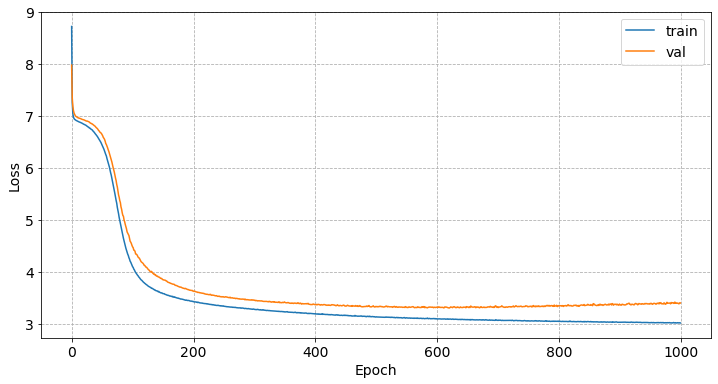

In [11]:
# Base line (HingeLoss)
model, tloss, vloss = output_data[0]
plot_values({'train': tloss, 'val': vloss})

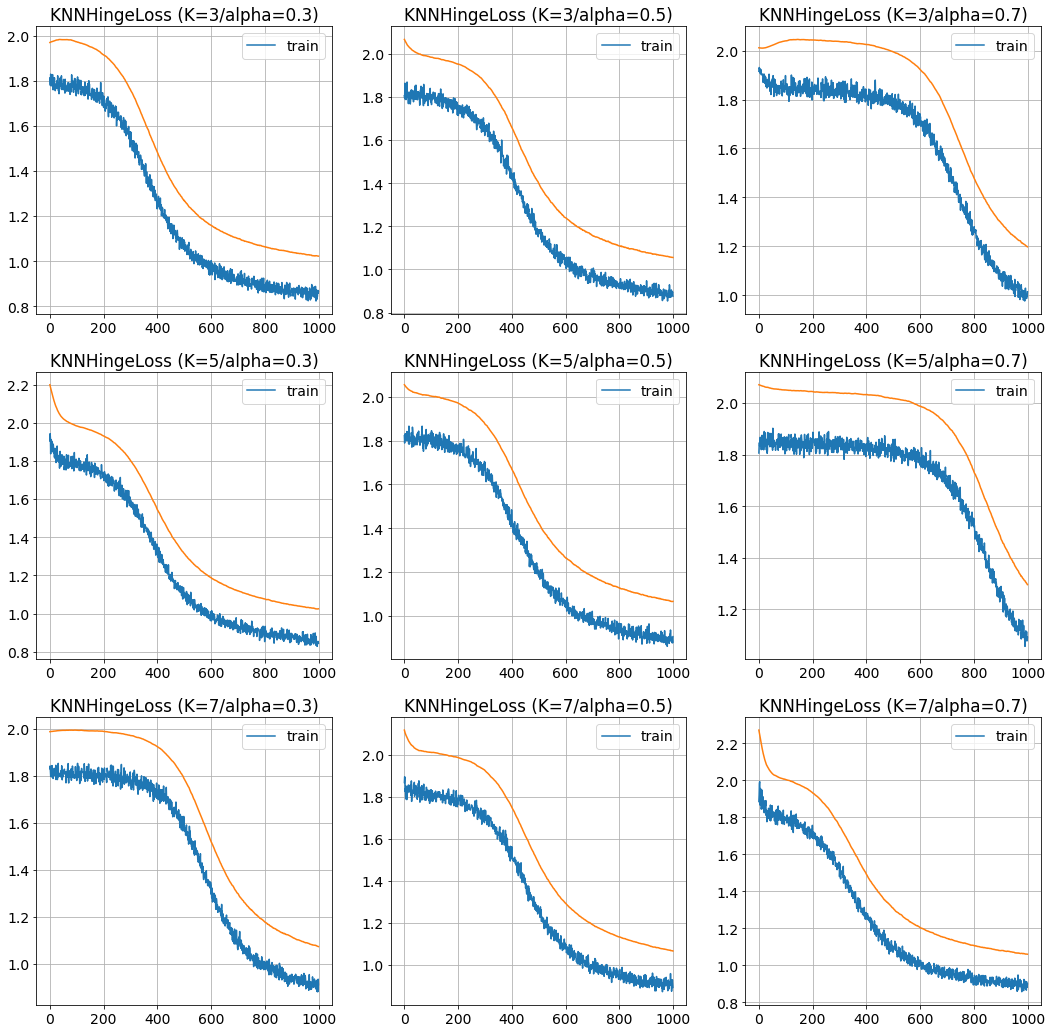

In [12]:
# KNN Hinge Loss
plt.figure(figsize=(18, 18))
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plt.subplot(3, 3, idx + 1)
    plt.grid('--')
    plt.plot(tloss, label='train')
    plt.plot(vloss)
    plt.legend()
    plt.title(losses[idx + 1][0])

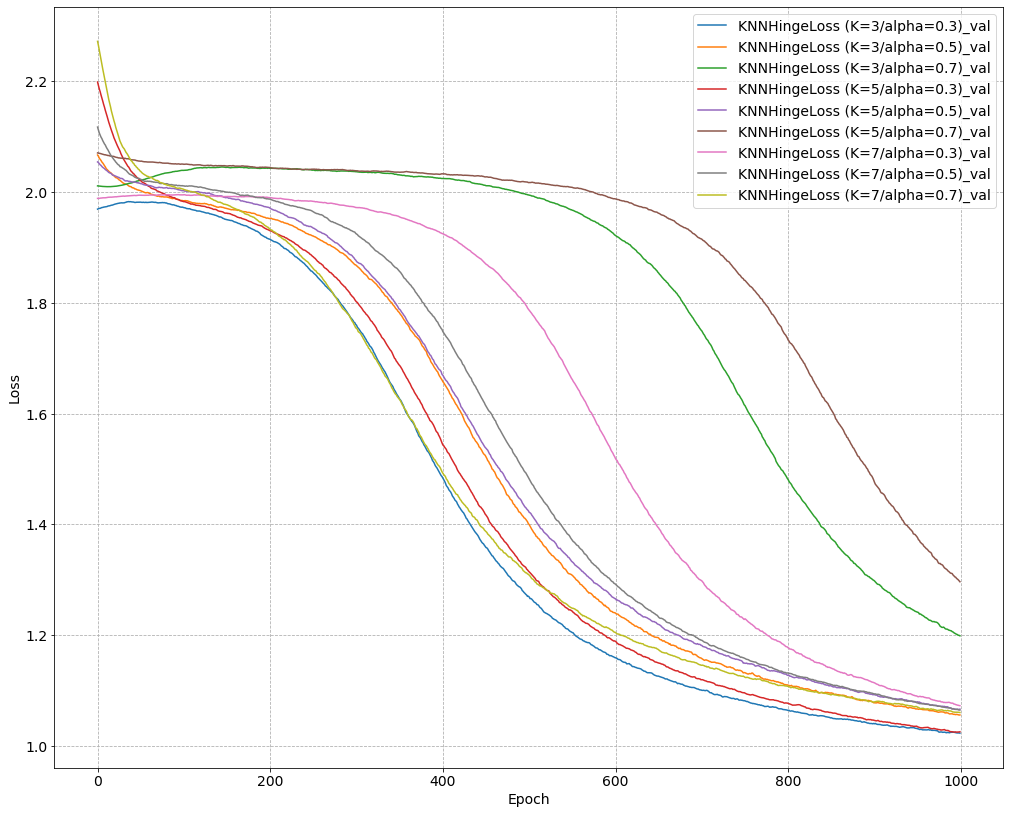

In [13]:
plot_all_data = {}
for idx, (model, tloss, vloss) in enumerate(output_data[1:]):
    plot_all_data[losses[idx + 1][0] + "_val"] = vloss
plot_values(plot_all_data, size=(17, 14))

In [14]:
# Evaluate output

evaluation_df = pd.DataFrame(columns=['name', 'acc', 'prec', 'recall', 'f1_score'])

for idx, (model, tloss, vloss) in enumerate(output_data):
    
    model_name = losses[idx][0]
    
    gt, predictions = [], []
    for data, label in test_dataloader:
        gt_label = max(label[0][0].item(), 0)
        gt.append(gt_label)
        with torch.no_grad():
            output = model(data)
        predictions.append(int(output.squeeze().item() > 0.5))
        
    evaluation_df = evaluation_df.append(
        pd.Series({
            'name': model_name,
            'acc': accuracy_score(gt, predictions),
            'prec': precision_score(gt, predictions),
            'recall': recall_score(gt, predictions),
            'f1_score': f1_score(gt, predictions)
        }),
        ignore_index=True
    )
    
evaluation_df

,name,acc,prec,recall,f1_score
0,HingeLoss,0.912281,1.000000,0.850746,0.919355
1,KNNHingeLoss (K=3/alpha=0.3),0.973684,0.957143,1.000000,0.978102
2,KNNHingeLoss (K=3/alpha=0.5),0.973684,0.970588,0.985075,0.977778
3,KNNHingeLoss (K=3/alpha=0.7),0.964912,0.956522,0.985075,0.970588
4,KNNHingeLoss (K=5/alpha=0.3),0.973684,0.957143,1.000000,0.978102
5,KNNHingeLoss (K=5/alpha=0.5),0.982456,0.971014,1.000000,0.985294
6,KNNHingeLoss (K=5/alpha=0.7),0.964912,0.970149,0.970149,0.970149
7,KNNHingeLoss (K=7/alpha=0.3),0.973684,0.984848,0.970149,0.977444
8,KNNHingeLoss (K=7/alpha=0.5),0.964912,0.970149,0.970149,0.970149
9,KNNHingeLoss (K=7/alpha=0.7),0.973684,0.970588,0.985075,0.977778
